d:\Asus\Ungdung\Miniconda\workspace\envs\learn_langraph\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


Number of mask channels: 1
Running inference with input_points: [[[1172, 812], [1572, 800]]]


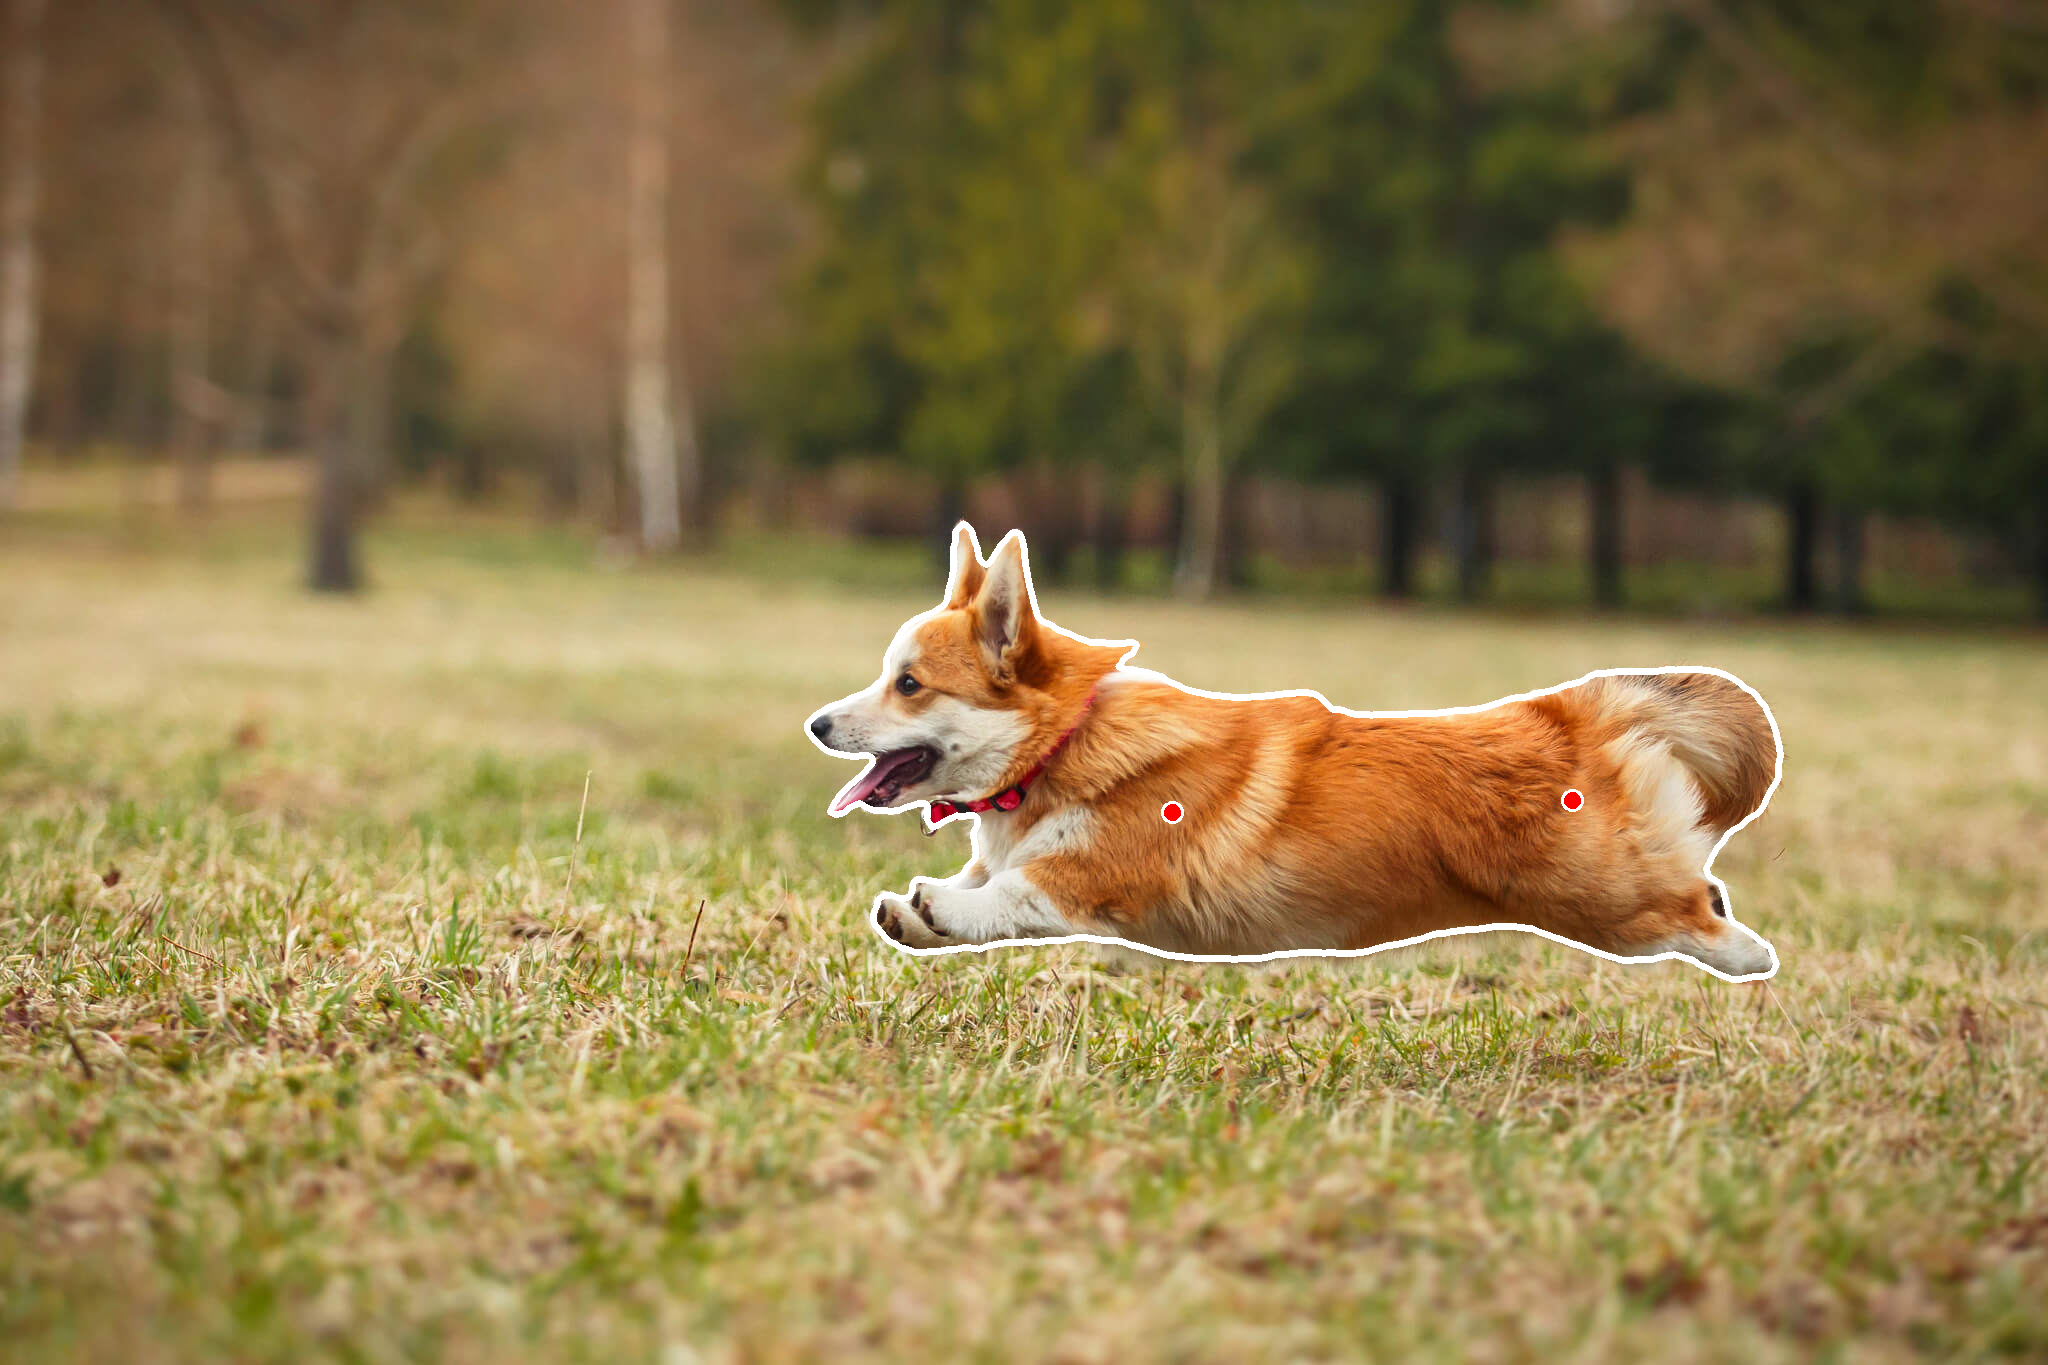

Description:
Candidates: answer1(0.00), answer2(0.00), answer3(0.00), answer4(0.00), answer5(0.00)
Running inference with input_boxes: [[[800, 500, 1800, 1000]]]


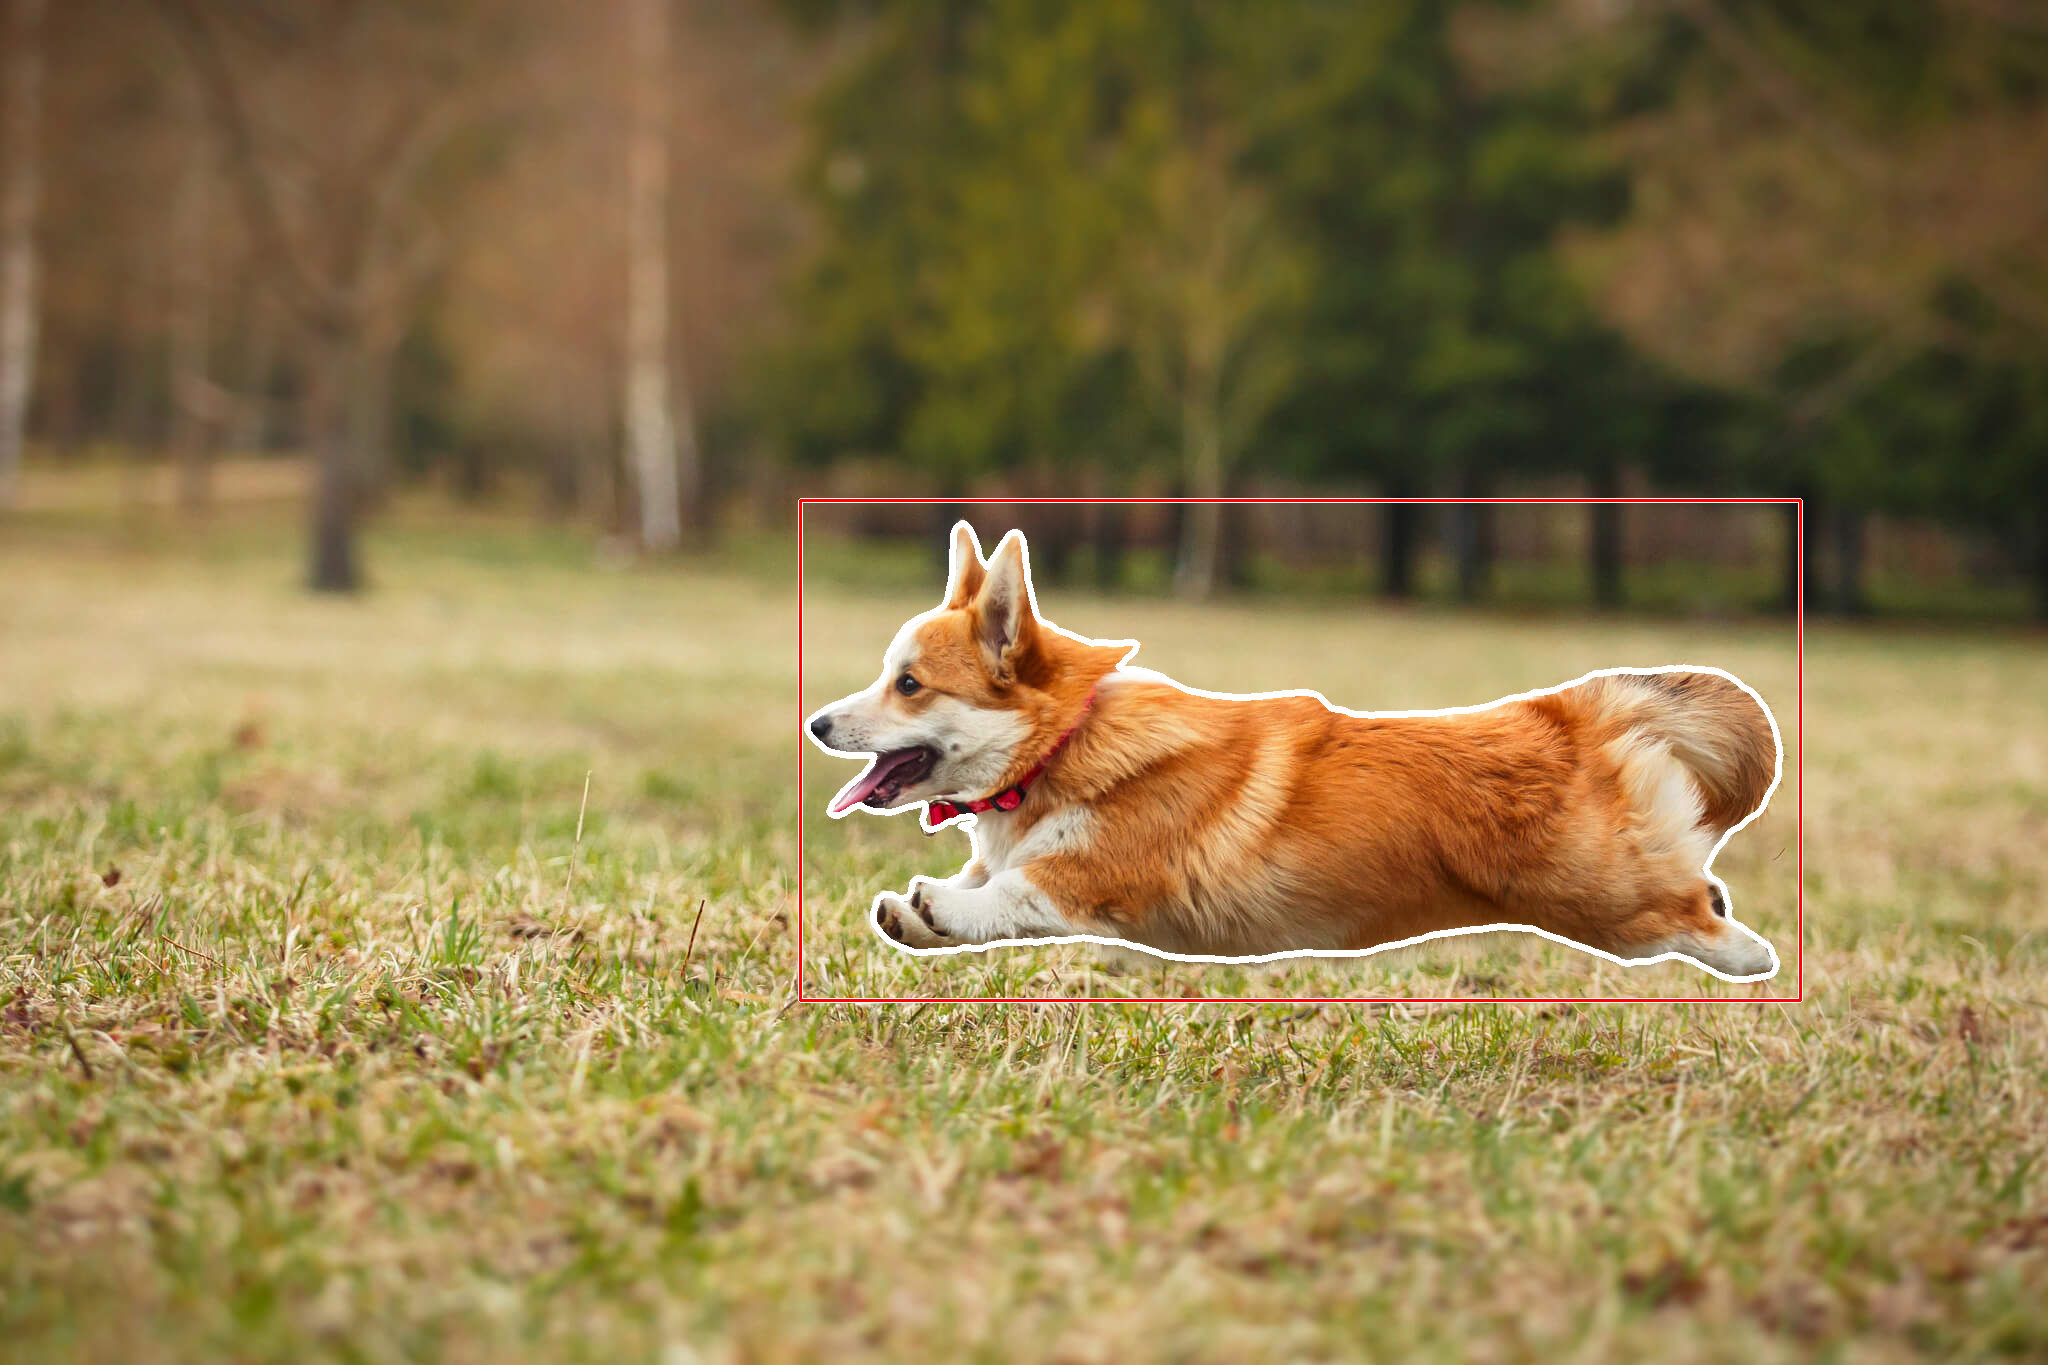

Description:
Candidates: answer1(0.00), answer2(0.00), answer3(0.00), answer4(0.00), answer5(0.00)


In [1]:
# Copyright 2025 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# SPDX-License-Identifier: Apache-2.0

import torch
import numpy as np
from PIL import Image
from transformers import SamModel, SamProcessor, AutoModel
import cv2
import requests
from io import BytesIO


def apply_sam(image, input_points=None, input_boxes=None, input_labels=None):
    inputs = sam_processor(image, input_points=input_points, input_boxes=input_boxes,
                           input_labels=input_labels, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = sam_model(**inputs)

    masks = sam_processor.image_processor.post_process_masks(
        outputs.pred_masks.cpu(),
        inputs["original_sizes"].cpu(),
        inputs["reshaped_input_sizes"].cpu()
    )[0][0]
    scores = outputs.iou_scores[0, 0]

    mask_selection_index = scores.argmax()
    mask_np = masks[mask_selection_index].numpy()
    return mask_np


def add_contour(img, mask, input_points=None, input_boxes=None):
    img = img.copy()
    mask = mask.astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img, contours, -1, (1.0, 1.0, 1.0), thickness=6)

    if input_points is not None:
        for points in input_points:
            for x, y in points:
                cv2.circle(img, (int(x), int(y)), radius=10, color=(1.0, 0.0, 0.0), thickness=-1)
                cv2.circle(img, (int(x), int(y)), radius=10, color=(1.0, 1.0, 1.0), thickness=2)

    if input_boxes is not None:
        for box_batch in input_boxes:
            for box in box_batch:
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(img, (x1, y1), (x2, y2), color=(1.0, 1.0, 1.0), thickness=4)
                cv2.rectangle(img, (x1, y1), (x2, y2), color=(1.0, 0.0, 0.0), thickness=2)

    return img

def print_streaming(text):
    print(text, end="", flush=True)

if __name__ == '__main__':
    # Download the image via HTTP
    image_url = 'https://github.com/NVlabs/describe-anything/blob/main/images/1.jpg?raw=true'
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).convert('RGB')

    device = torch.device("cpu")
    sam_model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
    sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
    image_size = img.size  # (width, height)

    # Initialize DAM model once
    model = AutoModel.from_pretrained(
        'nvidia/DAM-3B-Self-Contained',
        trust_remote_code=True,
        torch_dtype='torch.float16'
    ).to("cuda")
    dam = model.init_dam(conv_mode='v1', prompt_mode='full+focal_crop')

    # Define two runs: one with points, one with box
    runs = [
        {
            'use_box': False,
            'points': [[1172, 812], [1572, 800]],
            'output_image_path': 'output_visualization_points.png'
        },
        {
            'use_box': True,
            'box': [800, 500, 1800, 1000],
            'output_image_path': 'output_visualization_box.png'
        }
    ]

    for run in runs:
        if run['use_box']:
            # Prepare box input
            coords = run['box']
            input_boxes = [[coords]]
            print(f"Running inference with input_boxes: {input_boxes}")
            mask_np = apply_sam(img, input_boxes=input_boxes)
            vis_points = None
            vis_boxes = input_boxes
        else:
            # Prepare point input
            pts = run['points']
            input_points = [pts]
            input_labels = [[1] * len(pts)]
            print(f"Running inference with input_points: {input_points}")
            mask_np = apply_sam(img, input_points=input_points, input_labels=input_labels)
            vis_points = input_points
            vis_boxes = None

        # Convert mask and describe
        mask = Image.fromarray((mask_np * 255).astype(np.uint8))
        # Save visualization with contour
        img_np = np.asarray(img).astype(float) / 255.0
        img_with_contour_np = add_contour(img_np, mask_np,
                                          input_points=vis_points,
                                          input_boxes=vis_boxes)
        img_with_contour_pil = Image.fromarray((img_with_contour_np * 255.0).astype(np.uint8))
        img_with_contour_pil.save(run['output_image_path'])
        # print(f"Output image with contour saved as {run['output_image_path']}")
        display(img_with_contour_pil)
        question = "What color is the dog's fur?"
        print("Description:")
        for token in dam.get_description(
            img,
            mask,
            f"""<image>\nYou are a Visual Question Answering system.
                Given an image and a question, you must propose the top 5 candidate answers, each with a confidence score (from 0.00 to 1.00), sorted in descending order.
                – Base your answers only on clearly visible information in the image, without any external inference.
                – Output only one line in the following exact format:
                Candidates: answer1(score1), answer2(score2), answer3(score3), answer4(score4), answer5(score5)

                Example 1:
                Question: What color is the car in the image?
                Candidates: red(0.98), orange(0.75), yellow(0.40), brown(0.15), white(0.05)

                Example 2:
                Question: How many people are visible?
                Candidates: two(0.92), three(0.60), one(0.30), four(0.10), zero(0.02)

                Now apply to the new case:

                Question: {question.strip()}
                Answer:""",
            streaming=True,
            temperature=0.2,
            top_p=0.5,
            num_beams=1,
            max_new_tokens=512
        ):
            print_streaming(token)
        print()  # newline